In [2]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import cv2

Using TensorFlow backend.


In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


In [4]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


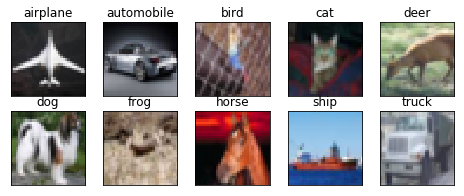

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

### Base Accuracy is 83.8% achieved at 95th epoch

### The model above shows some amount of overfitting and this would require some kind of regularization.
### Re-Running the model with below changes 
1. Using Image Normalization
2. Making use of Batch Normalization
3. Making use of L2 Regularizer
4. Properly using Dropout
5. Removed Dense layers
6. Overall reduced number of parameters from 1,172,410 to 290,090

### Results: Achieved a better accuracy of 84.33 % in just 15th Epoch. Ran the model further and achieved 86.36 % in 45th Epoch & 87.53 % in 89th Epoch

In [13]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()


print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainy, batch_size=128)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(128, 32, 32, 3) 0.01989002 1.0052702
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy
                        

In [0]:
from keras.callbacks import Callback

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [0]:
from keras import *

In [0]:
# Define the model
def get_model():

  model1 = Sequential()
  model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.2))

  model1.add(Convolution2D(32, 1, 1))


  model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.3))

  model1.add(Convolution2D(32, 1, 1))


  model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.5))

  model1.add(Convolution2D(10, 1, 1))

  model1.add(AveragePooling2D(pool_size = (4,4)))
  model1.add(Flatten())


  model1.add(Activation('softmax'))

  return model1

# Compile the model
# model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])


In [0]:
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(X_train.shape[0]/128))
model1.fit(X_train, Y_train, callbacks=[lr_finder] )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1
11552/50000 [=====>........................] - ETA: 57s - loss: 3.5756 - acc: 0.2118

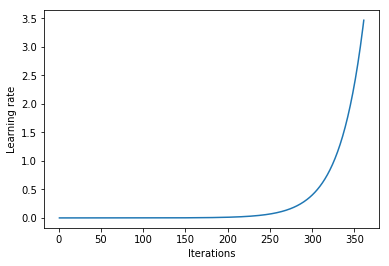

In [0]:
lr_finder.plot_lr()

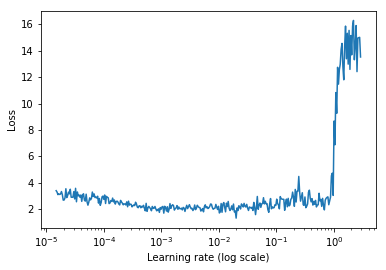

In [0]:
lr_finder.plot()

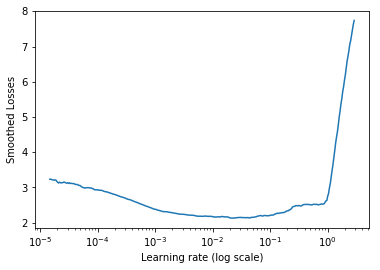

In [0]:
lr_finder.plot_smoothed_loss()

In [0]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)       

In [0]:

!git clone https://github.com/yu4u/cutout-random-erasing.git

Cloning into 'cutout-random-erasing'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (23/23), done.


In [0]:
!mv cutout-random-erasing/*   ./

In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
np.random.uniform(1, 100) * 32* 32

4048.299903295925

In [0]:
!ls

cifar10_resnet.py  example.ipynb  LICENSE	    README.md
example2.png	   example.png	  random_eraser.py  sample_data


### Total params: 455,370

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 15s 38ms/step - loss: 1.4166 - acc: 0.5095 - val_loss: 1.2080 - val_acc: 0.6091
Epoch 2/50
390/390 [==============================] - 12s 32ms/step - loss: 0.9982 - acc: 0.6655 - val_loss: 0.9095 - val_acc: 0.7014
Epoch 3/50
390/390 [==============================] - 12s 31ms/step - loss: 0.8307 - acc: 0.7289 - val_loss: 0.8052 - val_acc: 0.7453
Epoch 4/50
390/390 [==============================] - 12s 31ms/step - loss: 0.7257 - acc: 0.7678 - val_loss: 0.7678 - val_acc: 0.7547
Epoch 5/50
390/390 [==============================] - 12s 31ms/step - loss: 0.6574 - acc: 0.7950 - val_loss: 0.7266 - val_acc: 0.7771
Epoch 6/50
390/390 [==============================] - 12s 31ms/step - loss: 0.6070 - acc: 0.8139 - val_loss: 0.6379 - val_acc: 0.8051
Epoch 7/50
390/390 [==============================] - 12s 31ms/step - loss: 0.5714 - acc: 0.8281 - val_loss: 0.7018 - val_acc: 0.7830
Epoch 8/50
390/390 [==============================] - 12s 31ms

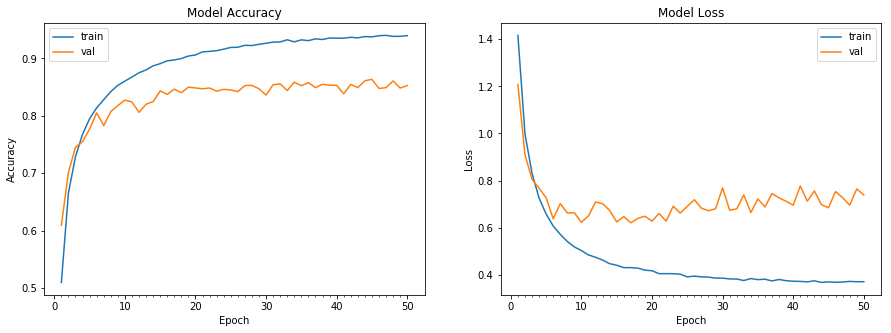

Accuracy on test data is: 85.27


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (X_test, Y_test), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

### Achieved 86.36 % in 45th Epoch.

### Ran for 50 more epochs and achieved 87.53 % as shown below in 39th epoch (total 89th epoch)

Epoch 1/50
  5/390 [..............................] - ETA: 14s - loss: 0.3692 - acc: 0.9250

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


390/390 [==============================] - 12s 31ms/step - loss: 0.3682 - acc: 0.9400 - val_loss: 0.6768 - val_acc: 0.8641
Epoch 2/50
390/390 [==============================] - 12s 31ms/step - loss: 0.3663 - acc: 0.9407 - val_loss: 0.7125 - val_acc: 0.8625
Epoch 3/50
390/390 [==============================] - 12s 31ms/step - loss: 0.3600 - acc: 0.9430 - val_loss: 0.7315 - val_acc: 0.8527
Epoch 4/50
390/390 [==============================] - 12s 31ms/step - loss: 0.3676 - acc: 0.9408 - val_loss: 0.7169 - val_acc: 0.8585
Epoch 5/50
390/390 [==============================] - 12s 31ms/step - loss: 0.3656 - acc: 0.9409 - val_loss: 0.6823 - val_acc: 0.8652
Epoch 6/50
390/390 [==============================] - 12s 31ms/step - loss: 0.3577 - acc: 0.9449 - val_loss: 0.7294 - val_acc: 0.8517
Epoch 7/50
390/390 [==============================] - 12s 31ms/step - loss: 0.3610 - acc: 0.9437 - val_loss: 0.6719 - val_acc: 0.8658
Epoch 8/50
390/390 [==============================] - 12s 31ms/step - los

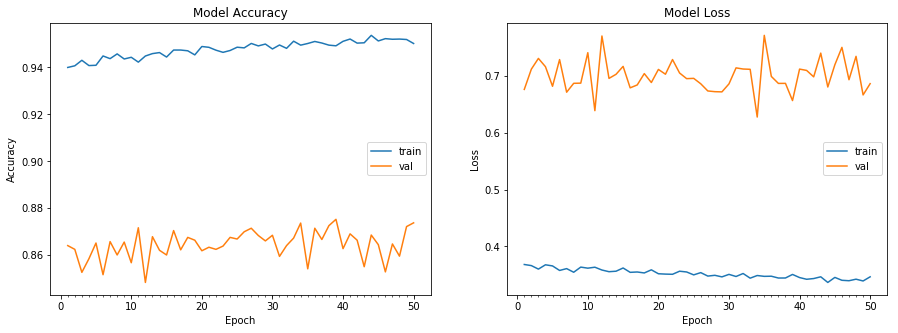

Accuracy on test data is: 87.38


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (X_test, Y_test), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

## Adding cut out and training by taking 0.01 learning rate as the optimal one from the graph

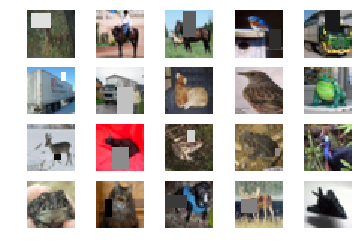

In [32]:
temp=train_features[10:31]

eraser = get_random_eraser(v_h=1,v_l=0,s_h=0.2,s_l=0.015)
rows=4;cols=5
for i in range(20):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(eraser(temp[i]), interpolation="nearest")
    plt.axis('off')

In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,

        preprocessing_function=get_random_eraser(v_l=0, v_h=1))



In [0]:
model1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [21]:
%cd /gdrive/'My Drive'/EVA2019

/gdrive/My Drive/EVA2019


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=10)`
  app.launch_new_instance()


Epoch 1/10
390/390 [==============================] - 28s 72ms/step - loss: 1.5218 - acc: 0.4632 - val_loss: 1.4565 - val_acc: 0.5173

Epoch 00001: val_acc improved from -inf to 0.51730, saving model to Best_weights_cifar_assignment11.hdf5
Epoch 2/10
390/390 [==============================] - 26s 67ms/step - loss: 1.1533 - acc: 0.6056 - val_loss: 1.1651 - val_acc: 0.6087

Epoch 00002: val_acc improved from 0.51730 to 0.60870, saving model to Best_weights_cifar_assignment11.hdf5
Epoch 3/10
390/390 [==============================] - 26s 67ms/step - loss: 1.0211 - acc: 0.6520 - val_loss: 0.9419 - val_acc: 0.6760

Epoch 00003: val_acc improved from 0.60870 to 0.67600, saving model to Best_weights_cifar_assignment11.hdf5
Epoch 4/10
390/390 [==============================] - 26s 67ms/step - loss: 0.9282 - acc: 0.6871 - val_loss: 0.8103 - val_acc: 0.7320

Epoch 00004: val_acc improved from 0.67600 to 0.73200, saving model to Best_weights_cifar_assignment11.hdf5
Epoch 5/10
390/390 [===========

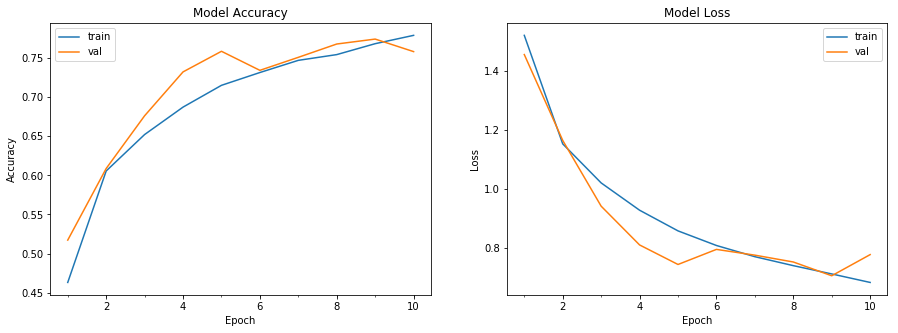

Accuracy on test data is: 75.79


In [55]:
from keras.callbacks import ModelCheckpoint
filepath="Best_weights_cifar_assignment11.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(zoom_range=0.0, 
#                              horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels),callbacks=[checkpoint], verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model1))

Epoch 1/90
  2/390 [..............................] - ETA: 33s - loss: 0.7333 - acc: 0.7773

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=90)`
  """


390/390 [==============================] - 26s 67ms/step - loss: 0.6629 - acc: 0.7852 - val_loss: 0.6156 - val_acc: 0.8064

Epoch 00001: val_acc improved from 0.77390 to 0.80640, saving model to Best_weights_cifar_assignment11.hdf5
Epoch 2/90
390/390 [==============================] - 26s 68ms/step - loss: 0.6429 - acc: 0.7919 - val_loss: 0.6864 - val_acc: 0.7934

Epoch 00002: val_acc did not improve from 0.80640
Epoch 3/90
390/390 [==============================] - 27s 69ms/step - loss: 0.6199 - acc: 0.8019 - val_loss: 0.6262 - val_acc: 0.8046

Epoch 00003: val_acc did not improve from 0.80640
Epoch 4/90
390/390 [==============================] - 27s 68ms/step - loss: 0.6067 - acc: 0.8078 - val_loss: 0.6570 - val_acc: 0.7983

Epoch 00004: val_acc did not improve from 0.80640
Epoch 5/90
390/390 [==============================] - 27s 69ms/step - loss: 0.5900 - acc: 0.8122 - val_loss: 0.6129 - val_acc: 0.8111

Epoch 00005: val_acc improved from 0.80640 to 0.81110, saving model to Best_we

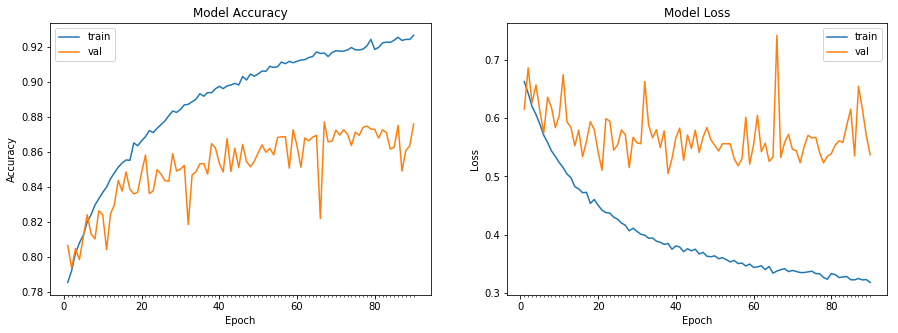

Accuracy on test data is: 87.60


In [56]:
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 90, 
                                 validation_data = (test_features, test_labels),callbacks=[checkpoint], verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model1))

In [28]:
model=get_model() 
model.load_weights('Best_weights_cifar_assignment11.hdf5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regulariz

In [29]:
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data is: 87.71


In [0]:
model1

In [0]:
labels_predicted=[np.argmax(i) for i in model.predict(test_features)]

In [0]:
actual_labels=[np.argmax(i) for i in test_labels]

In [0]:
import pandas as pd

In [0]:
misclassified_data=pd.DataFrame({'true_labels':actual_labels,'labels_predicted':labels_predicted})

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
class_id_to_name={i:j for i,j in enumerate(class_names)}

In [49]:
class_id_to_name

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [52]:
confusion_matrix(actual_labels,labels_predicted,labels=list(class_id_to_name.keys()))

array([[911,   8,  24,   8,   7,   0,   0,   2,  27,  13],
       [  3, 952,   1,   2,   1,   0,   1,   2,   5,  33],
       [ 42,   1, 864,  11,  41,  12,  17,   4,   4,   4],
       [ 15,   4,  63, 705,  34, 112,  31,  20,   6,  10],
       [  9,   1,  39,  20, 890,  10,  11,  16,   2,   2],
       [  7,   4,  46,  77,  27, 816,   8,  11,   2,   2],
       [ 10,   3,  36,  30,  20,   8, 881,   6,   2,   4],
       [  9,   1,  24,  14,  26,  23,   0, 897,   1,   5],
       [ 27,  13,   5,   3,   0,   1,   1,   2, 938,  10],
       [ 15,  45,   4,   3,   0,   1,   0,   1,  14, 917]])

In [46]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [53]:
misclassified_data['labels_predicted'].value_counts()

2    1106
0    1048
4    1046
1    1032
8    1001
9    1000
5     983
7     961
6     950
3     873
Name: labels_predicted, dtype: int64

In [54]:
misclassified_data['true_labels'].value_counts()

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
Name: true_labels, dtype: int64

In [0]:
idxs=list(misclassified_data[misclassified_data['true_labels']!=misclassified_data['labels_predicted']].index)

## Total no of misclassified_images

In [58]:
len(misclassified_index)

1229

## Image gallery of 25 misclassified_images

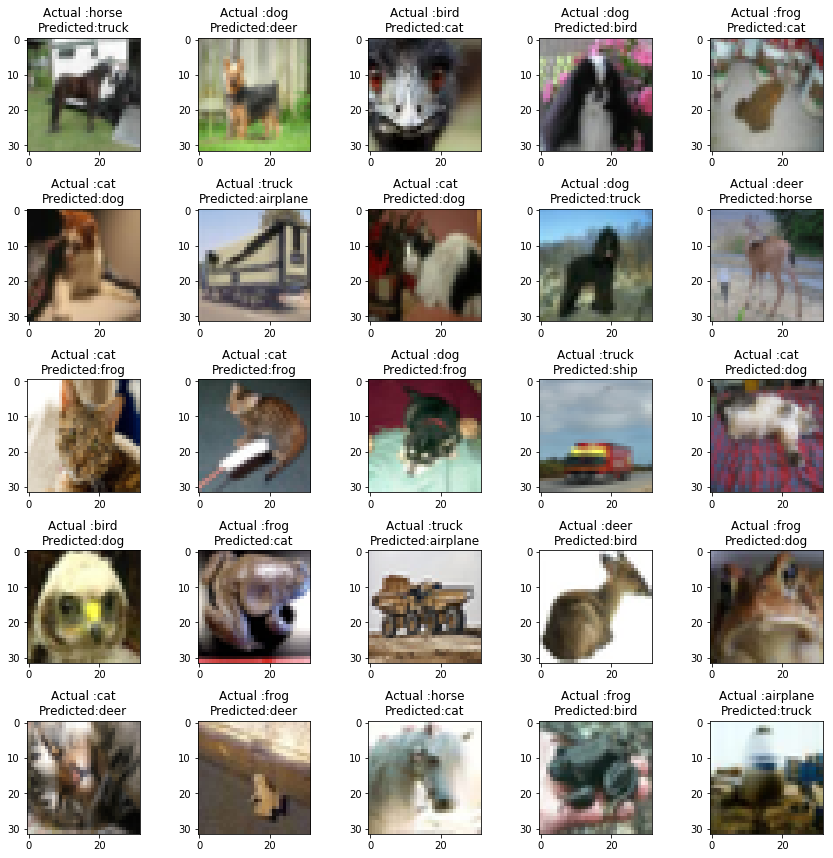

In [62]:

fig=plt.figure(figsize=(12, 12))
columns = 5
rows = 5
for i in range(1, columns*rows+1 ):
    img = test_features[idxs[i]]
    Str="Actual :"+str(class_id_to_name[actual_labels[idxs[i]]])+"\nPredicted:"+str(class_id_to_name[labels_predicted[idxs[i]]])
    fig.add_subplot(rows, columns, i,).set_title(Str)
    plt.imshow(img,)

plt.tight_layout(True)
plt.show()

In [0]:
from sklearn.metrics import classification_report

In [0]:
actual_label_names=[class_id_to_name[i] for i in actual_labels]
predicted_label_names=[class_id_to_name[i] for i in labels_predicted]

In [67]:
print(classification_report(actual_label_names,predicted_label_names))

              precision    recall  f1-score   support

    airplane       0.87      0.91      0.89      1000
  automobile       0.92      0.95      0.94      1000
        bird       0.78      0.86      0.82      1000
         cat       0.81      0.70      0.75      1000
        deer       0.85      0.89      0.87      1000
         dog       0.83      0.82      0.82      1000
        frog       0.93      0.88      0.90      1000
       horse       0.93      0.90      0.91      1000
        ship       0.94      0.94      0.94      1000
       truck       0.92      0.92      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## It can be seen that cat predictions are mostly misclassified

In [0]:
def visualize_GradCam(img,layer_name='conv2d_16'):


  x = img
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer_name)
  print(class_names[class_idx])
#   plt.imshow(img)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(conv_layer_output_value.shape[-1]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)    


  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  
  ##Changing the range of values to [1,255] so that they can be taken in by applyColorMap function
  
  heatmap = np.uint8(255*heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  ##Chnaging the range again between [0,1]
  
  heatmap=heatmap.astype('float32')/255

  superimposed_img = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)
  
  return heatmap,superimposed_img

In [0]:
def show_gradcam(img,layer_name='conv2d_16'):
  

  

  heatmap,superimposed_img=visualize_GradCam(img,layer_name)



  images = []
  images.append(img)
  images.append(heatmap)

  images.append(superimposed_img)

  titles = ['Original Image','HeatMap','gradCam Image']
  f = plt.figure(figsize=(15,15))

  for i in range(len(images)):
      plt.subplot(1,3,i+1),plt.imshow(images[i])
      plt.title(titles[i])
      plt.xticks([]),plt.yticks([])

  plt.show()

ship


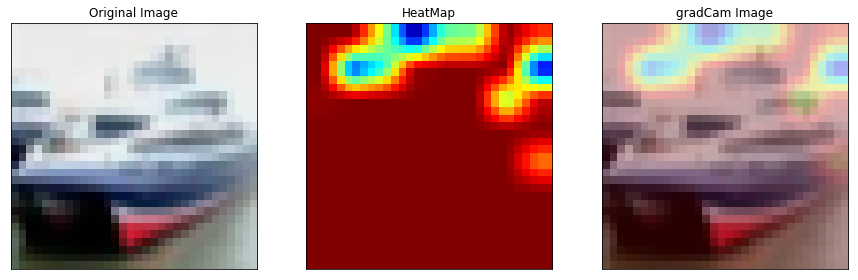

In [87]:
show_gradcam(test_features[1])

## Image gallery of the gradcam_on misclassified images

truck
deer
cat
bird
cat
dog
airplane
dog
truck
horse
frog
frog
frog
ship
dog
dog
cat
airplane
bird
dog
deer
deer
cat
bird
truck


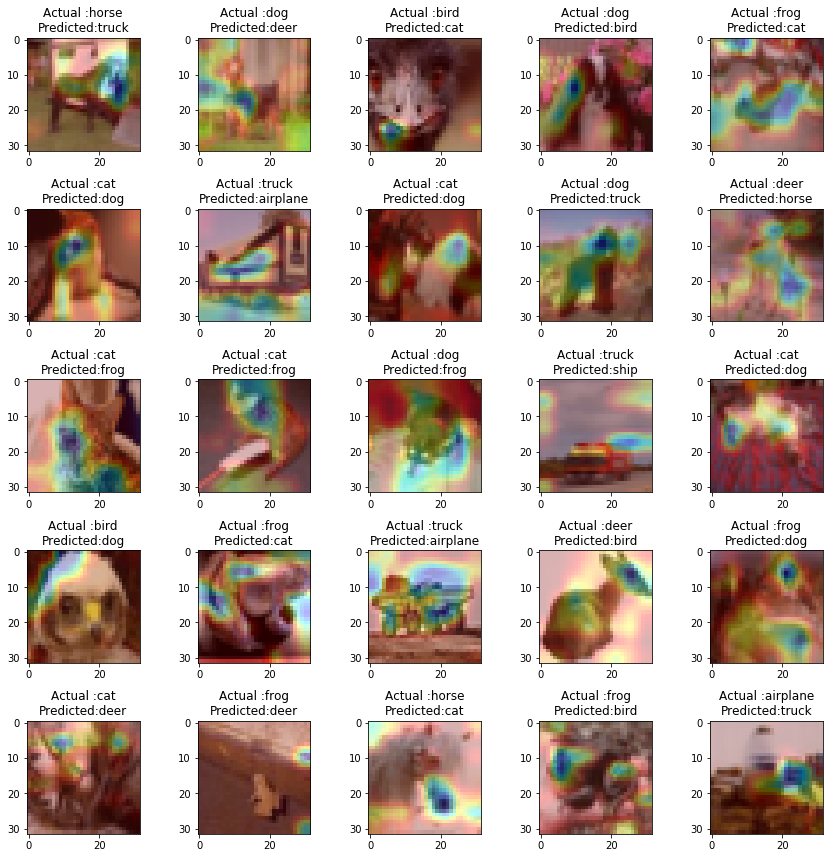

In [90]:
fig=plt.figure(figsize=(12, 12))
columns = 5
rows = 5
for i in range(1, columns*rows+1 ):
    img = test_features[idxs[i]]
    _,superimposed_img=visualize_GradCam(img)
    Str="Actual :"+str(class_id_to_name[actual_labels[idxs[i]]])+"\nPredicted:"+str(class_id_to_name[labels_predicted[idxs[i]]])
    fig.add_subplot(rows, columns, i,).set_title(Str)
    plt.imshow(superimposed_img)

plt.tight_layout(True)
plt.show()